In [127]:
import os
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

## TODOS

* OpenCV Landmarks analysieren unn verstehen (MARIUS)
* Aussreisser erkennung über dataframes laufen lassen (ROBIN)
* Welche Glenkpunkte sind wichtiger als andere? (PERRY)

# Task-2c: Evalutation 

> Test the quality from the extracted data - plausibility checks shall be performed checking
* The absolute values for each keypoint (outliers ?)
* The values for each keypoint over time (anomalies?)
* The values for each keypoint relative to other keypoints (anomalies ?)


> Für das endgültige Ziel, einen passenden Laufschuh für jede Laufart zu finden, müssen die Daten wie folgt aufbereitet werden:
* Für jedes Video Außreisser finden und beseitigen
* Folge: Jeder Dataframe je Video hat unterschidlich viele Werte, da die Außreisser unterschiedlich sein werden
* Jede Laufgeschwindigkeit hat 2 Videos (Perspektiven) und somit je zwei Werte zu denseleben Keypoints. Diese müssen zu einem gemeinsamen Wert verrechnet werden.

### Get Data
* Reading Data from all CSV Files and save it to multiple Dataframes. 
* Storing every df into a Dictionary for further purposes

In [128]:
df_dict_all = {}

csvFilesPath = os.getcwd()+"/csv_files/"
csvFiles = os.listdir(csvFilesPath)

for fileName in csvFiles:
    #print(fileName)
    pre, ext = os.path.splitext(fileName)
    file = csvFilesPath + fileName

    #test if file ok 
    df = pd.read_csv(file)
    df_dict_all[pre] = df
    if len(df) < 1798:
        print(pre)

amountDataframes = len(df_dict_all)
amountColumns = len(df.columns.tolist())
amountRows = len(df)+1
amountData = amountDataframes*amountColumns*amountRows

print(f'{amountDataframes} DataFrames')
print(f'{amountColumns} columns per Dataframe ')
print(f'{amountRows} rows per Dataframe')
print(f'{amountData} DataCells')

60 DataFrames
132 coluns per Dataframe 
1800 rows per Dataframe
14256000 DataCells


* 10 Runner
* 3 paces per runner
* 2 perspectives per pace 
> 10 x 3 x 2 = 60 Dataframes


* 1800 Frames per Dataframe --> 1800 Frames / 60 seconds = 30 Frames per Second
* 132 Columns per Dataframe --> 33 Pivot points x 4 Columns per Pivotpoint


> Für die 33 relevanten Keypoints gibt es in jedem Dataframe 4 Spalten mit Werten:
* x -->  Bildbreite (Werte normalisiert auf [0,0, 1,0])
* y -->  Bildhöhe (Werte normalisiert auf [0,0, 1,0])
* z -->  Bildtiefe (Werte normalisiert auf [0,0, 1,0])
* v -->  Sichtbarkeit (Werte normalisiert auf [0,0, 1,0]) 



In [129]:
#print(df_dict_all.keys())
# df = df_dict_all[list(df_dict_all.keys())[2]]
# df2 = df_dict_all[list(df_dict_all.keys())[3]]
df = df_dict_all["Gehen-7_geschnitten"]
df2 = df_dict_all["Gehen-7_hinten_geschnitten"]
df3 = df_dict_all["Joggen-7_geschnitten"]
df4 = df_dict_all["Joggen-7_hinten_geschnitten"]
df5 = df_dict_all["Laufen-7_geschnitten"]
df6 = df_dict_all["Laufen-7_hinten_geschnitten"]

### Which Data are relevant?
Not all landmarks are required for our UseCase. Previous research has shown that all points above the hip are irrelevant. These are removed from the data record for subsequent processing.

* Relevant landmarks: >=23
* Irrlevenate Landmarks: <23

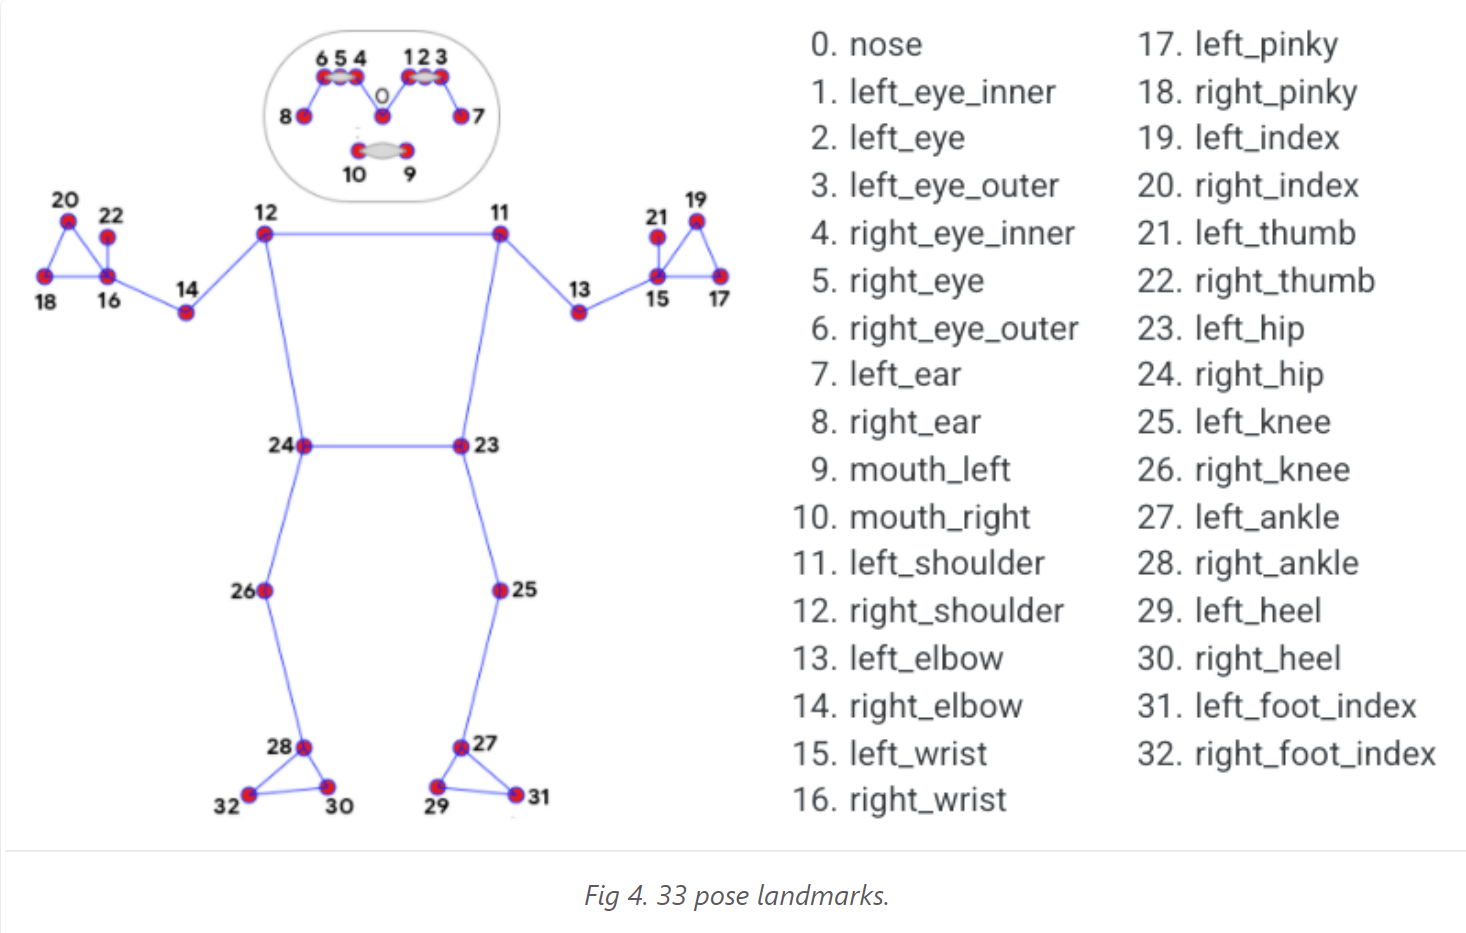

In [130]:
from IPython.display import display, Image
display(Image(filename='landmarks.png'))

In [131]:
#create DFs with relevant Data
landmarks_all = df.columns.tolist()
landmarks_relevant = landmarks_all[-40:]

df_side_gehen =  df[landmarks_relevant]
df_back_gehen = df2[landmarks_relevant]

df_side_joggen =  df3[landmarks_relevant]
df_back_joggen = df4[landmarks_relevant]

df_side_laufen =  df5[landmarks_relevant]
df_back_laufen = df6[landmarks_relevant]

In [132]:
import pandas as pd
import plotly.express as px

df_side = df_side_gehen
df_back = df_back_gehen

#hüfte
fig_side = px.line(df_side, y="x24", title='Position LEFT_Hüfte')
fig_back = px.line(df_back, y="z24")
fig_back.update_traces(line= dict(
    color = "green"
))

fig_side.add_trace(fig_back.data[0], )
fig_side.show()

#knee
fig_side = px.line(df_side, y="x26", title='Position LEFT_Knee')
fig_back = px.line(df_back, y="z26")
fig_back.update_traces(line= dict(
    color = "green"
))

fig_side.add_trace(fig_back.data[0], )
fig_side.show()

#foot
fig_side = px.line(df_side, y="x28", title='Position LEFT_foot')
fig_back = px.line(df_back, y="z28")
fig_back.update_traces(line= dict(
    color = "green"
))

fig_side.add_trace(fig_back.data[0],)
fig_side.show()
#df

## Outlier Detection

### Univariate outlier detection 
based on descriptive statistics (three standard deviations) can be useful to identify extreme outliers

In [133]:
def getOutliers(dff):
    '''Analyze given df and return relevant Data per Video'''
    
    feature_list = dff.columns
    outliers_dict = {}#dict for storing outlierts for an outlier summary df
    outliers_plot_dict = {}#dict for plotting outliers in scatterplot
    outlier_list_unique = []
    outliers_dict_length = {}
    #print("Potential Outliers:")
    for feature in feature_list:
        feature_data = dff[feature]
        
        df_feature = pd.DataFrame(feature_data)
        df_feature["outlier"] = 0

        three_std=feature_data.std()*3
        mean=feature_data.mean()

        inlier_low=mean-three_std
        inlier_high=mean+three_std

        outlier_list = [] #list for storing indexes of outliers
        for i, value in enumerate(feature_data):
            if value < inlier_low or value > inlier_high:
                outlier_list.append(i)
                df_feature.iloc[i,1] = 1      

        #print(f'{feature} detected: {len(outlier_list)}')
        if not len(outlier_list) == 0:
            outliers_dict[str(feature)]=outlier_list
            outliers_plot_dict[str(feature)]=df_feature
            outliers_dict_length[str(feature)] = len(outlier_list)
            outlier_list_unique =  list(set(outlier_list_unique) | set(outlier_list))
        #print(type(df_feature), df_feature.head())

    #store indexes from the original df of every potential outlier existing in a new df for every column
    df_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in outliers_dict.items() ]))

    first_key = list(outliers_plot_dict.keys())[0]
    x24_outliers = outliers_plot_dict[first_key]
    return outliers_dict_length, outliers_plot_dict, outlier_list_unique

Iterate through ervery File and detect the outliers

In [134]:
#print(getOutliers(df_side_gehen))
columnNames = ['x24', 'y24', 'z24', 'v24', 'x25', 'y25', 'z25', 'v25', 'x26', 'y26',
       'z26', 'v26', 'x27', 'y27', 'z27', 'v27', 'x28', 'y28', 'z28', 'v28',
       'x29', 'y29', 'z29', 'v29', 'x30', 'y30', 'z30', 'v30', 'x31', 'y31',
       'z31', 'v31', 'x32', 'y32', 'z32', 'v32', 'x33', 'y33', 'z33', 'v33']
       
outlier_true_list = {}
df_outlier_side = pd.DataFrame(columns = columnNames)
df_outlier_back = pd.DataFrame(columns = columnNames)

for i, df_vid in enumerate(list(df_dict_all.values())):
    df_vid = df_vid[[*columnNames]]
    outliersDict, df_outlier_true, outlier_list_unique  = getOutliers(df_vid)
    
    name_vid = list(df_dict_all.keys())[i]
    outlier_true_list[str(name_vid[:-12])] = {"DF": df_outlier_true, "INDEX": outlier_list_unique}
    #print(name_vid[:-12])
    series = pd.Series(outliersDict, name=str(name_vid[:-12]))
    
    if "hinten" in str(name_vid):
        df_outlier_back = df_outlier_back.append(series, ignore_index=False)
    else:
        df_outlier_side = df_outlier_side.append(series, ignore_index=False)

df_outlier_side = df_outlier_side.fillna(0)
df_outlier_back = df_outlier_back.fillna(0)
outlier_summary_list = [df_outlier_side,df_outlier_back ]
#print(df_outlier_side.head())



In [136]:
videoName = "Joggen-7"
landmark = "x24"

dict_all_df = outlier_true_list[videoName]["DF"] #dict with values and outlier True or not per video for All landmarks
ListOutliersIndexUnique = outlier_true_list[videoName]["INDEX"]#List with unique index values per video for ALL Landmarks
df_per_landmark = dict_all_df[landmark] #df per landmark with values and outlier True or not 

df_per_landmark

# key = list(outlier_true_list["Joggen-8_hinten"].keys())[0]
# PAAALO = outlier_true_list["Joggen-8_hinten"][key]
# PAAALO
#PAAALO.loc[PAAALO['x25'] == 1]

,x24,outlier
0,0.446721,1
1,0.439859,1
2,0.437029,1
3,0.426878,1
4,0.420293,1
...,...,...
1794,0.562895,0
1795,0.574187,0
1796,0.583440,0
1797,0.584211,0


Create Excel

In [137]:
excelFilesPath = os.getcwd()+"/excel_files/"  
fileName = "outlierSummary"
with pd.ExcelWriter(excelFilesPath+ fileName + '.xlsx') as writer:  
       
    df_outlier_side.to_excel(writer, sheet_name='side')
    df_outlier_back.to_excel(writer, sheet_name='back')
   

Plot Summary of the amount of Outliers detected 

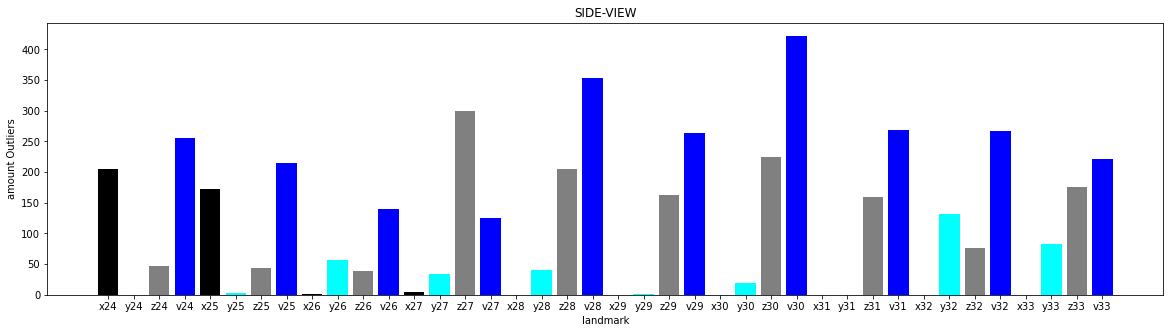

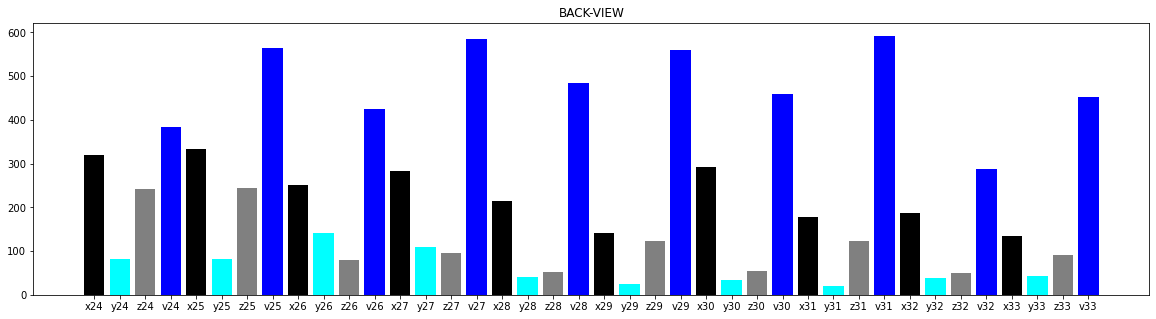

In [139]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 5)) 
plt.xlabel("landmark") 
plt.ylabel("amount Outliers") 
plt.title("SIDE-VIEW")
ywerte = df_outlier_side.sum().tolist()
xwerte = columnNames
plt.bar(xwerte, ywerte, color=['black', 'cyan', 'grey', 'blue'])

plt.show()

fig = plt.figure(figsize = (20, 5)) 
plt.title("BACK-VIEW")
ywerte = df_outlier_back.sum().tolist()
xwerte = columnNames
plt.bar(xwerte, ywerte, color=['black', 'cyan', 'grey', 'blue'])
plt.show()

## Erkentnisse Ausreisser

* Horizontalen Bewegung Seitenansicht
> Die Seitenansicht zeigt, dass die Punkte x24 und x25 (Hüfte) die größte Anzahl an Ausreissern aufweist.
--> Ursache: Bewegung auf dem Laufband: Bsp.: Video Gehen_7

(Dies könnte damit zusammenhängen, dass diese beiden Punkte eine relativ geringe Bewegung nach links und rechts durch die natürliche Laufbewegung haben. Bei der Betrachtung der Videos ist aufgefallen, dass die Läufer sich teilweise mit dem kompletten Körper nach vorne und hinten bewegen. )

* Sichtbarkeit
> Die Sichtbarkeit für die linke und rechte Seite eines Gelenkpunktes, sollten mindestens einen ähnlichen Wert aufweissen.
Die Grafik zeigt, dass der linke Gelenkpunkt einen immer geringeren Wert als der rechte aufzeigt.
--> potentielle Ursache: Kamerawinkel minimal schrägt

* Umgebung
> Vermutlich sind einige Aussreisser aufgrund Personen im Hintergrund/Vordergrung entstanden: Bsp.: Laufen_hinten_9

## FRAGEN

* Für unterschiedliche Winkel die wir berechnen wollen bietet sich eine Perspektive eher an als die andere
    --> Deshalb Daten aus den beiden perspektiven getrennt betrachent?
* Macht es sinn Aussreisser für jede Perspektive einzeln zu identifiezieren und zu entfernen?
    --> Folge: unterschiedlich viele Werte für das Selbe Video

* 14 Millionen Datensätze zu viel? (3.iwas Mio)
    --> Videos kürzen ? Dadurch weniger Datensätze

* negative werte in mediapipe pose model
    --> laut mediapipe liegt der wertebereich zwischen 0 und 1

* Videoaufnahme mit in die Prsäsentation?